<a href="https://colab.research.google.com/github/yl540016/PortfolioProjects/blob/main/optimizing_taxi_fleet_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amount of orders prediction for Taxi

Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the
amount of taxi orders for the next hour. Build a model for such a prediction.
The RMSE metric on the test set should not be more than 48.

# Preparation

### Importing required libraries

In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00


## Loading data

In [2]:
data = pd.read_csv('./taxi.csv', index_col=[0], parse_dates=[0])
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Preparation

Let's have a look on first rows of the data set.

In [4]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Let's specify the index column and parse the datetime. Also, let's reample the dataset by the hour.

In [5]:
df_taxi = pd.read_csv('./taxi.csv', parse_dates=True, index_col=['datetime'])
df_taxi.sort_index(inplace=True)
df_taxi = df_taxi.resample('1H').sum()

In [6]:
display(df_taxi.head(10))
df_taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Analysis

In [7]:
def plotRollingMean(data, size):
    rolling_mean = data.rolling(size).mean()

    plt.figure(figsize=(15,5))
    plt.plot(data[size:], label="Original Values", alpha=0.6)
    plt.plot(rolling_mean, 'r', label="Rolling Mean")
    plt.legend(loc="upper left")

    plt.xlabel('Date')
    plt.ylabel('Number of Orders')
    plt.title('Original Data w/ Rolling Mean\n Size: {}'.format(size))

To make the data smoother and make it easier to identify the trends, let's compare the rolling mean using one-day, 7-day, 14-day windows.

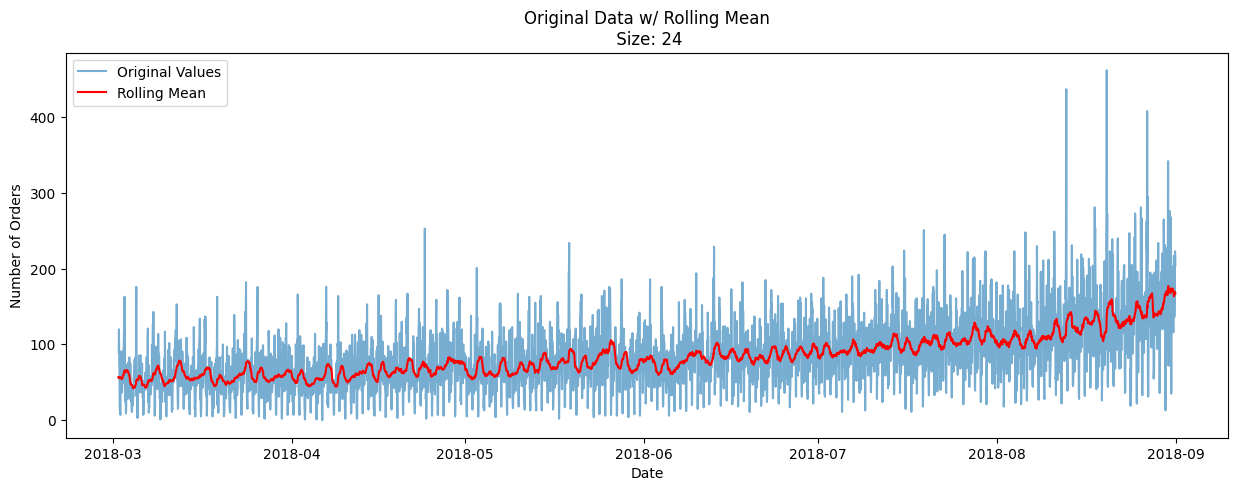

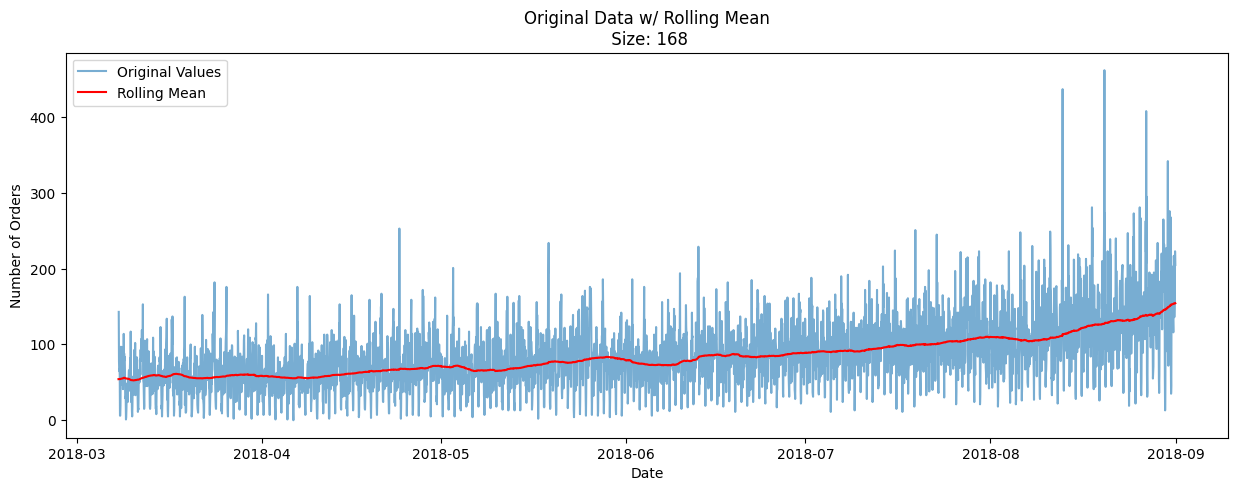

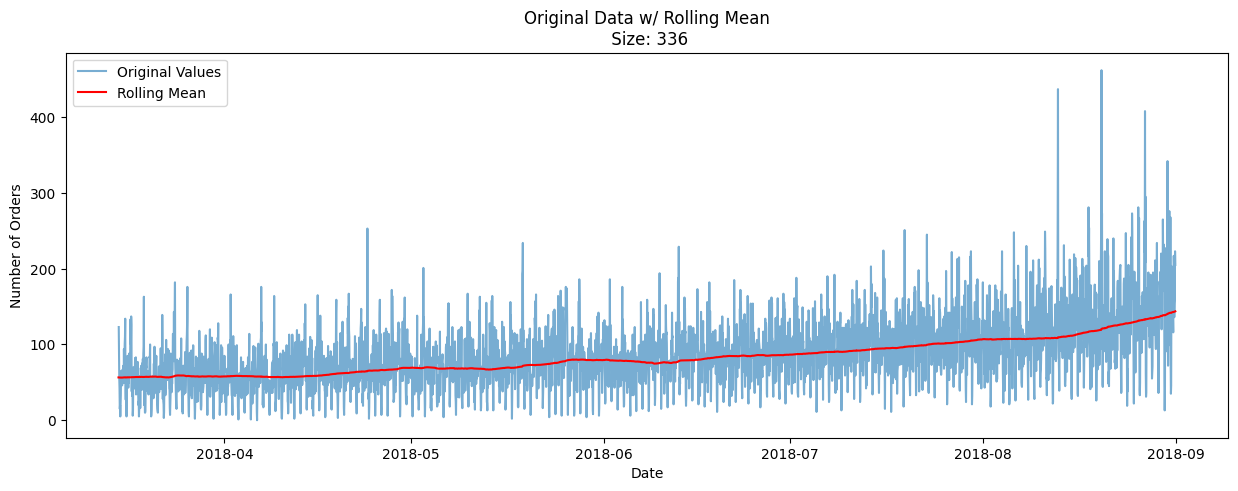

In [8]:
plotRollingMean(df_taxi, 24)
plotRollingMean(df_taxi, 168)
plotRollingMean(df_taxi, 336)


The seven-day rolling mean displays a relatively stable trend.

For Feature Engineering, we'll choose for a one-week rolling window to retain ample data. The charts indicate a **gradual increase** trend in total taxi orders over time.

### Seasonality

Due to the size and interval of the dataset, I'll examine the seasonality by 'zooming' in on the data for the months of March and August.

Text(0.5, 1.0, 'Seasonal Decomposition: August')

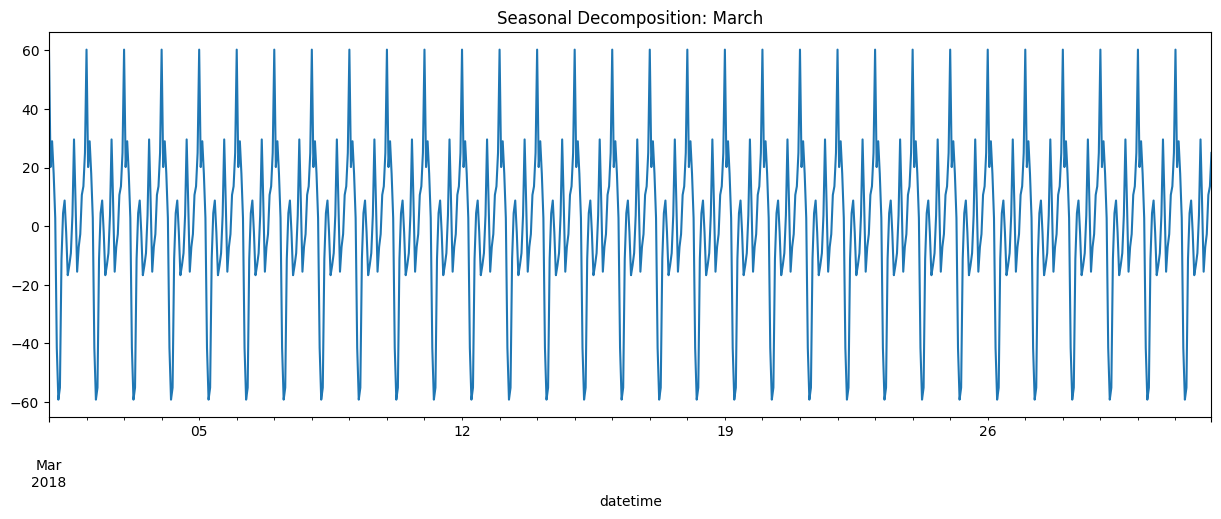

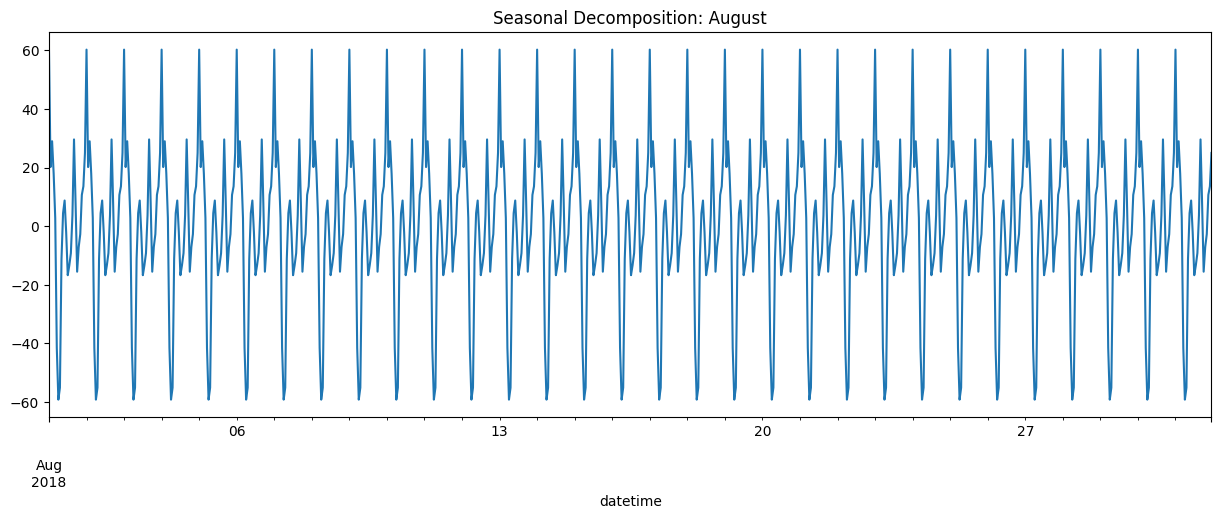

In [9]:
decomposed = seasonal_decompose(df_taxi)
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-03-01':'2018-03-31'].plot()
plt.title ('Seasonal Decomposition: March')

plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-08-01':].plot()
plt.title ('Seasonal Decomposition: August')

The data seems to show daily seasonal patterns, with regular times each day experiencing peaks in the number of orders that rise above and fall below the established trend line.

#### Auto vs. Partial Autocorrelation Function

Finally, we'll examine the autocorrelation and partial autocorrelation function plots to assess the potential impact of lag features on model training.

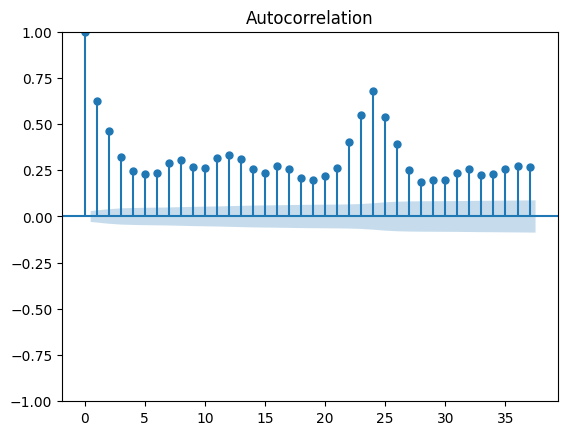

In [10]:
ax = plot_acf(df_taxi)
plt.show()


The autocorrelation plot reveals a significant influence from earlier data points in the series, diminishing as the time gap from the current observation increases, particularly after about 8 hours, yet it shows a cyclical pattern every 24 hours, indicating a potential correlation between the time of day and order volume.

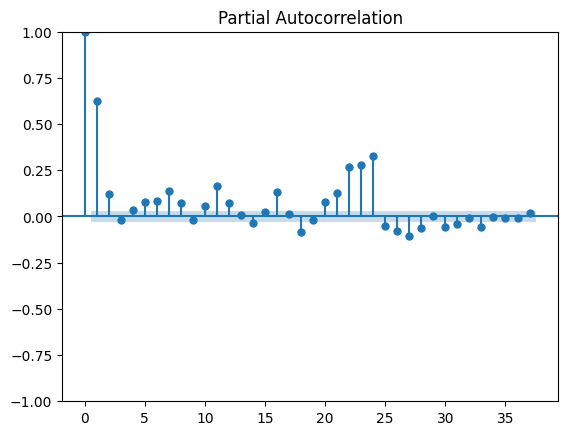

In [11]:
ax = plot_pacf(df_taxi, method='ywm')
plt.show()

In the partial autocorrelation plot, there's limited correlation beyond the data point just before the current one, except for a slight increase in correlation at the 24-hour mark, hinting at the importance of the time of day in determining order numbers

## Feature Engineering

The dataset displays overall periodic trends, so we will extract features such as the month, day, and day of the week.

In [12]:
df_taxi['dayofweek'] = df_taxi.index.dayofweek
df_taxi['day'] = df_taxi.index.day
df_taxi['month'] = df_taxi.index.month

Considering our findings on seasonality and autocorrelation, we will generate lag features spanning a 24-hour period.

In [13]:
for lag in range(1, 25):
    df_taxi['lag_{}'.format(lag)] = df_taxi['num_orders'].shift(lag)

Furthermore, we will include the rolling average as a feature, using a one-week window size. It's crucial to use the* shift()* function to prevent data leakage.

In [14]:
df_taxi['rolling_mean'] = df_taxi['num_orders'].shift().rolling(168).mean()

Then, let's drop the null values.

In [15]:
df_taxi.dropna(inplace=True)

In [16]:
display(df_taxi.head(10))

,num_orders,dayofweek,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,94.0,127.0,108.0,76.0,50.0,99.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,54.226190
2018-03-08 01:00:00,78,3,8,3,143.0,94.0,127.0,108.0,76.0,50.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,54.339286
2018-03-08 02:00:00,65,3,8,3,78.0,143.0,94.0,127.0,108.0,76.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,54.297619
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,54.261905
2018-03-08 04:00:00,60,3,8,3,68.0,65.0,78.0,143.0,94.0,127.0,...,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,54.273810
2018-03-08 05:00:00,6,3,8,3,60.0,68.0,65.0,78.0,143.0,94.0,...,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,10.0,54.375000
2018-03-08 06:00:00,6,3,8,3,6.0,60.0,68.0,65.0,78.0,143.0,...,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,19.0,54.375000
2018-03-08 07:00:00,19,3,8,3,6.0,6.0,60.0,68.0,65.0,78.0,...,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,17.0,54.339286
2018-03-08 08:00:00,77,3,8,3,19.0,6.0,6.0,60.0,68.0,65.0,...,46.0,51.0,43.0,55.0,34.0,58.0,34.0,50.0,38.0,54.363095


## Training and Evaluation

To streamline our model comparison process, we'll create the `training_and_evaluation()` function with the following specifications:

### Parameters:
- `model`: The predictive model to be trained and assessed.
- `train_valid_feat`: An array-like structure containing the feature set of the combined training and validation datasets.
- `train_valid_tgt`: An array-like structure holding the target values for the combined training and validation datasets.
- `params`: A dictionary containing specified hyperparameter values, defaulting to an empty dictionary if none are provided.

### Returns:
- The function returns the best performing model from the grid search. It also outputs the optimal cross-validation score and the hyperparameter settings for the best model.

### Functionality:
- Within each iteration of the grid search's k-fold validation, the function will employ the `MaxAbsScaler()` to scale the training dataset.


In [17]:
def train_and_evaluate(model, train_valid_feat, train_valid_tgt, params={}):
    tscv = TimeSeriesSplit(n_splits=5)
    ct = ColumnTransformer([('scaler', MaxAbsScaler(), train_valid_feat.columns)])
    pipe = Pipeline([('col_transform' , ct), ('model', model)])

    grid_pipeline = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)
    grid_pipeline.fit(train_valid_feat, train_valid_tgt)

    print('Best score: ', grid_pipeline.best_score_)
    print('Best parameters: ', grid_pipeline.best_params_)

    return grid_pipeline.best_estimator_

#### Split the dataset

The final 10% of the data will serve as the test set. Moreover, for the linear regression model, a validation set will be established to facilitate comparison of model evaluations, given the absence of hyperparameter tuning for this model.

In [18]:
train_valid, test = train_test_split(df_taxi, shuffle=False, test_size=0.10)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.10)

# train, valid set for Linear Regression model
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
valid_features = valid.drop('num_orders', axis=1)
valid_target = valid['num_orders']

print(train_features.shape, train_target.shape)
print(valid_features.shape, valid_target.shape)

(3440, 28) (3440,)
(383, 28) (383,)


In [19]:
# combined train valid set for GridSearchCV
train_valid_features = train_valid.drop('num_orders', axis=1)
train_valid_target = train_valid['num_orders']

print(train_valid_features.shape, train_valid_target.shape)

# final test set
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

print(test_features.shape, test_target.shape)

(3823, 28) (3823,)
(425, 28) (425,)


### Linear Regression

Linear Regression model will be our baseline.

In [20]:
LinearRegression_model = LinearRegression()
LinearRegression_model.fit(train_features, train_target)

print('RMSE: ', mean_squared_error(valid_target, LinearRegression_model.predict(valid_features), squared=False))

RMSE:  35.14541873875118


#### Decision Tree Regressor

In [21]:
DecisionTree_model = DecisionTreeRegressor(random_state=12345)
DecisionTree_model.fit(train_features, train_target)

print('Tree depth: ', DecisionTree_model.get_depth())
print('Default DT RMSE: ', mean_squared_error(valid_target, DecisionTree_model.predict(valid_features), squared=False))

Tree depth:  30
Default DT RMSE:  44.400709189170676


Tune the hyperparameters

In [23]:
params_dt = {'model__max_depth': list(range(3,31)),
             'model__min_samples_split': [2, 4, 6],
             'model__min_samples_leaf': [0.1, 0.5, 1, 5, 10],
             'model__max_features': [None, 'sqrt', 'log2']}

grid_dt = train_and_evaluate(DecisionTreeRegressor(random_state=12345), train_valid_features, train_valid_target, params=params_dt)

Best score:  -29.615282444886144
Best parameters:  {'model__max_depth': 7, 'model__max_features': None, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}


By adjusting the hyperparameters to a max_depth of 7 and min_samples_leaf of 10, while keeping other parameters at their default values, we achieved a lower RMSE score around 29.6, indicating an improvement in the model's performance.

#### Random Forest Regressor

In [24]:
rf_model = RandomForestRegressor(random_state=12345)
rf_model.fit(train_features, train_target)

est_list = []
for est in rf_model.estimators_:
    est_list.append(est.get_depth())

print('Shortest tree: ', min(est_list))
print('Tallest tree: ', max(est_list))
print('RMSE: ', mean_squared_error(valid_target, rf_model.predict(valid_features), squared=False))

Shortest tree:  22
Tallest tree:  36
RMSE:  33.013053787335934


Tuned the hyperparameters.

In [25]:
params_rf = {'model__n_estimators': [10, 25, 50, 75, 100],
             'model__max_depth': list(range(10, 36, 5)),
             'model__max_features': [None, 'sqrt', 'log2']}

grid_rf = train_and_evaluate(RandomForestRegressor(random_state=12345), train_valid_features, train_valid_target, params=params_rf)

Best score:  -25.988487695443997
Best parameters:  {'model__max_depth': 25, 'model__max_features': 'sqrt', 'model__n_estimators': 75}


Setting the model with hyperparameters of max_depth at 25, max_features set to 'sqrt', and n_estimators at 75 resulted in a refined RMSE score, slightly below 26.

## Testing


From the outcomes mentioned earlier, we will proceed to assess the Random Forest regressor on our test dataset, applying the optimized hyperparameter settings.

In [26]:
best_model = grid_rf
test_predict = best_model.predict(test_features)

print('Final RMSE: ', mean_squared_error(test_target, test_predict, squared=False))

Final RMSE:  43.517293607955885



The final RMSE score of approximately 43.5 suggests potential overfitting in our model. By plotting the predicted values against the actual targets, we can identify where the most significant discrepancies in our predictions occurred.

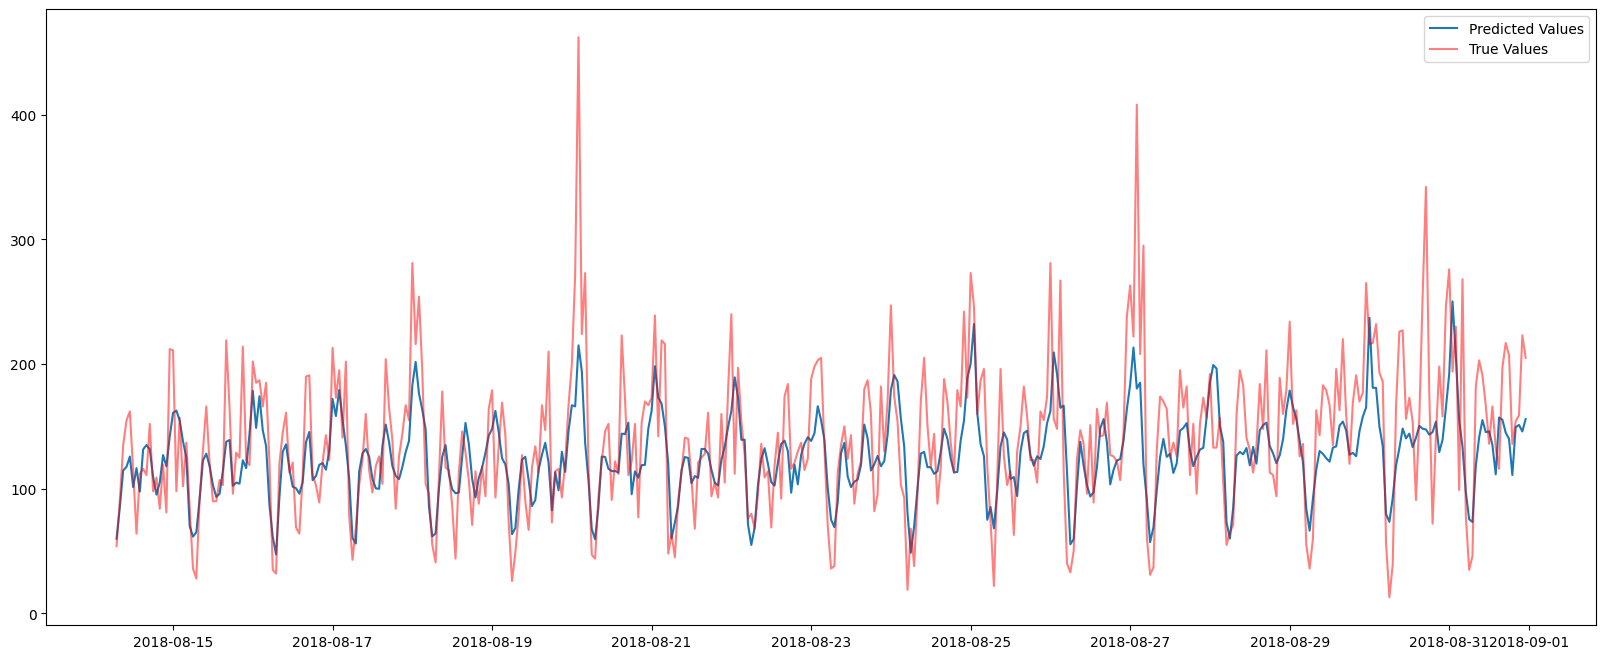

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(test_features.index, test_predict)
plt.plot(test_features.index, test_target, color='red', alpha=0.5)
plt.legend(['Predicted Values','True Values'])
plt.show()


The most substantial errors seem to have occurred in instances where the model failed to accurately forecast spikes in the volume of orders.

## Conclusion

In this initiative, we developed and assessed various models to forecast taxi order volumes using a time series dataset. Although the final assessment indicated overfitting, it also pinpointed opportunities for enhancement. With such data, it's feasible to refine engineered features for more accurate prediction of demand surges, possibly by adjusting the rolling mean's trend smoothing through an optimal window size and reassessing the quantity of lag features used.


To elevate the model's efficacy, integrating external, non-engineered factors—like the locations of taxi pickups and drop-offs—could be key. Such features, influencing taxi service demand, would not only enhance the model but also emphasize the significance of feature importance, complementing or superseding trend analysis in time series data.